![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png)  ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
# PEC 2: Parte 2, Marzo 2023

## Extracción de conocimiento de fuentes de datos heterogéneas mediante Spark SQL, RDDs y GraphFrames

En esta práctica vamos a introducir estructuras de datos más complejas que las vistas hasta ahora, donde los campos pueden a su vez tener campos anidados. En concreto utilizaremos datos de twitter capturados en el contexto de las elecciones generales en España del 28 de Abril de 2019. La práctica está estructurada de la siguiente manera:
- **Parte 0:** Configuración del entorno
- **Parte 1:** Introducción a data frames estructurados y cómo operar extraer información *(3 puntos)*
    - **Parte 1.1:** Importar los datos *(1 puntos)*
    - **Parte 1.2:** *Queries* sobre sobre data frames complejos *(2 puntos)*
        - **Parte 1.2.1:** Queries SQL *(1 puntos)*
        - **Parte 1.2.2:** Queries sobre el pipeline *(1 puntos)*
- **Parte 2:** Bases de datos HIVE y operaciones complejas *(3 puntos)*
    - **Parte 2.1:** Bases de datos Hive *(1 puntos)*
    - **Parte 2.2:** Más allá de las transformaciones SQL *(2 puntos)*
        - **Parte 2.2.1:** Tweets por población  *(1 puntos)*
        - **Parte 2.2.2:** Contar hashtags *(1 puntos)*
- **Parte 3:** Sampling *(2 Puntos)*
- **Parte 4**: Introducción a los datos relacionales *(2 puntos)*
     - **Parte 4.1**: Construcción de la edgelist *(1 puntos)*
     - **Parte 4.2**: Centralidad de grado *(1 puntos)*


## **Parte 0:** Configuración del entorno

In [1]:
import findspark
findspark.init()

import re
import os
import pandas as pd
from matplotlib import pyplot as plt
from math import floor
from pyspark import SparkConf, SparkContext, SQLContext, HiveContext
from pyspark.sql import Row

import random
import pyspark
sc = pyspark.SparkContext(master="local[1]", appName="PEC3_erocho")
sqlContext = SQLContext(sc)


## **Parte 1:** Introducción a data frames estructurados y operaciones sobre ellos.

Como ya se ha mencionado, en esta práctica vamos a utilizar datos de Twitter que recolectamos durante las elecciones generales en España del 28 de abril de 2019. Como veremos, los tweets tienen una estructura interna bastante compleja que hemos simplificado un poco en esta práctica.

### **Parte 1.1:** Importar los datos

Lo primero que vamos ha aprender es cómo importar este tipo de datos a nuestro entorno. Uno de los tipos de archivos más comunes para guardar este formato de información es [la estructura JSON](https://en.wikipedia.org/wiki/JSON). Esta estructura permite guardar información en un texto plano de diferentes objetos siguiendo una estructura de diccionario donde cada campo tiene asignado una llave y un valor. La estructura puede ser anidada, o sea que una llave puede tener como valor otra estructura tipo diccionario.

Spark SQL permite leer datos de muchos formatos diferentes (como recordareis de la anterior práctica donde leímos un fichero CSV). En esta ocasión, se os pide que leáis un fichero JSON de la ruta ```/aula_22.419/data/tweets28a_sample.json```. Este archivo contiene un pequeño *sample*, un 0.1% de la base de datos completa (en un siguiente apartado veremos cómo realizar este *sampleado*). En esta ocasión no se os pide especificar la estructura del data frame ya que la función de lectura la inferirá automáticamente.


In [2]:
sqlContext = SQLContext(sc)
tweets_sample = sqlContext.read.json("/aula_22.419/data/tweets28a_sample.json")

print("Loaded dataset contains %d tweets" % tweets_sample.count())

Loaded dataset contains 27268 tweets


El siguiente paso es mostrar la estructura del dataset que acabamos de cargar. Recordad que podéis obtener la información acerca de cómo está estructurado el DataTable utilizando el método ```printSchema()```.

In [4]:
tweets_sample.printSchema()

root
 |-- _id: string (nullable = true)
 |-- created_at: long (nullable = true)
 |-- lang: string (nullable = true)
 |-- place: struct (nullable = true)
 |    |-- bounding_box: struct (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |-- type: string (nullable = true)
 |    |-- country_code: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- place_type: string (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- _id: string (nullable = true)
 |    |-- user: struct (nullable = true)
 |    |    |-- followers_count: long (nullable = true)
 |    |    |-- friends_count: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- lang: string (nullable = true)
 |    

Podéis observar que la estructura del tweet contiene múltiples campos anidados. Teneis que familiarizaros con esta estructura ya que será la que utilizaremos durante toda la práctica. Recordad también que no todos los tweets tienen todos los campos, como por ejemplo la ubicación (campo ```place```). Cuando esto pasa el campo pasa a ser ```NULL```. Podéis ver mas información sobre este tipo de datos en [este enlace](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object).

### **Parte 1.2:** *Queries* sobre sobre data frames complejos

En esta parte vamos a introducir conceptos sobre cómo trabajar con data tables.

#### **Parte 1.2.1:** Queries SQL

El primer paso consiste en registrar la tabla en el contexto SQL comprobando primero si existe y borrándola en el caso que sea así. En este apartado se os pide que registréis la tabla ```tweets_sample``` que acabamos de cargar en el contexto sql bajo el mismo nombre ```tweets_sample```.

In [5]:
#Primero comprobamos si hay algo para la tabla tweets_sample
sqlContext.sql("select * from tweets_sample LIMIT 10").collect()

AnalysisException: 'Table or view not found: tweets_sample; line 1 pos 14'

In [6]:
#Registramos
sqlContext.registerDataFrameAsTable(tweets_sample, "tweets_sample")

In [7]:
#Revisamos ahora si hay info de nuevo:
sqlContext.sql("select * from tweets_sample LIMIT 10").collect()

[Row(_id='1122569971345833984', created_at=1556476512, lang='und', place=None, retweeted_status=Row(_id='1122566927866634245', user=Row(followers_count=3109, friends_count=2978, id_str='301428215', lang='es', screen_name='Ibero_DMJ', statuses_count=52713)), text='RT @Ibero_DMJ: 😂😂😂😂😂 https://t.co/GkuSJPpboj', user=Row(followers_count=2511, friends_count=4383, id_str='1069389675645870080', lang='en', screen_name='jhlacasa1', statuses_count=3360)),
 Row(_id='1122570131736006656', created_at=1556476550, lang='pt', place=None, retweeted_status=None, text='@CervantesFAQs @Cazatalentos @vox_es @Irene_Montero_ Asco de gente y de V💩X!', user=Row(followers_count=33, friends_count=119, id_str='1030176768056012801', lang='es', screen_name='TeresaAngelin15', statuses_count=1838)),
 Row(_id='1122570215445999617', created_at=1556476570, lang='es', place=None, retweeted_status=Row(_id='1122561071426998273', user=Row(followers_count=1101665, friends_count=415, id_str='26729931', lang='es', screen_name

Ahora se os pide que creeis una tabla ```users_agg``` con [la información agregada](https://www.w3schools.com/sql/sql_groupby.asp) de los usuarios que tengan definido su idioma (```user.lang```) como español (```es```). En concreto se os pide que la tabla contenga las siguientes columnas:
- **screen_name:** nombre del usuario
- **friends_count:** número máximo (ver nota) de personas a las que sigue
- **tweets:** número de tweets realizados
- **followers_count:** número máximo (ver nota) personas que siguen al usuario.

El orden en el cual se deben mostrar los registros es orden descendente acorde al número de tweets.

***Nota:*** es importante que os fijéis que el nombre de *friends* i *followers* puede diferir a lo largo de la adquisición de datos. En este caso vamos ha utilizar la función de agregación ```MAX``` sobre cada uno de estos campos para evitar segmentar el usuario en diversas instancias.

In [8]:
users_agg = sqlContext.sql("""  SELECT user.screen_name, MAX(user.friends_count) AS friends_count, COUNT (_id) as tweets, MAX(user.followers_count) AS followers_count
                                FROM tweets_sample
                                WHERE user.lang == 'es'
                                GROUP BY user.screen_name
                                ORDER BY tweets DESC""")
users_agg.limit(10).show()

+---------------+-------------+------+---------------+
|    screen_name|friends_count|tweets|followers_count|
+---------------+-------------+------+---------------+
|       anaoromi|         6258|    16|           6774|
|    RosaMar6254|         6208|    14|           6245|
|        lyuva26|         3088|    13|           3732|
|PisandoFuerte10|         2795|    12|           1752|
|     carrasquem|          147|    12|            215|
|       jasalo54|         1889|    11|            689|
|  PabloChabolas|         4925|     9|           4042|
|      lolalailo|         4922|     9|           3738|
|     Lordcrow11|         5002|     9|           3069|
|    DuroBelinda|         5242|     9|           5778|
+---------------+-------------+------+---------------+



In [7]:
output = users_agg.first()
assert output.screen_name == 'anaoromi' and output.friends_count == 6258 and output.tweets == 16 and output.followers_count == 6774, "Incorrect output"

Imaginad ahora que queremos combinar la información que acabamos de generar con información acerca del número de veces que un usuario ha sido retuiteado. Para hacer este tipo de combinaciones necesitamos recurrir al [```JOIN``` de tablas](https://www.w3schools.com/sql/sql_join.asp). Primero debemos registrar la tabla que acabamos de generar en el contexto SQL. Recordad que primero debéis comprobar si la tabla existe y en caso afirmativo eliminarla ('drop table if exists <tabla>'). La tabla tenéis que registrarla bajo el nombre de ```user_agg```.

In [9]:
#Revisamos si existe:
sqlContext.sql("select * from user_agg LIMIT 10").collect()

AnalysisException: 'Table or view not found: user_agg; line 1 pos 14'

In [10]:
#Registramos:
sqlContext.registerDataFrameAsTable(users_agg,"user_agg")

In [11]:
#Revisamos de nuevo
sqlContext.sql("select * from user_agg LIMIT 10").collect()

[Row(screen_name='anaoromi', friends_count=6258, tweets=16, followers_count=6774),
 Row(screen_name='RosaMar6254', friends_count=6208, tweets=14, followers_count=6245),
 Row(screen_name='lyuva26', friends_count=3088, tweets=13, followers_count=3732),
 Row(screen_name='PisandoFuerte10', friends_count=2795, tweets=12, followers_count=1752),
 Row(screen_name='carrasquem', friends_count=147, tweets=12, followers_count=215),
 Row(screen_name='jasalo54', friends_count=1889, tweets=11, followers_count=689),
 Row(screen_name='lolalailo', friends_count=4922, tweets=9, followers_count=3738),
 Row(screen_name='Lordcrow11', friends_count=5002, tweets=9, followers_count=3069),
 Row(screen_name='DuroBelinda', friends_count=5242, tweets=9, followers_count=5778),
 Row(screen_name='PabloChabolas', friends_count=4925, tweets=9, followers_count=4042)]

Una vez registrada se pide que combinéis esta tabla y la tabla ```tweets_sample``` utilizando un ```INNER JOIN``` para obtener una nueva tabla con la siguiente información:
- ***screen_name:*** nombre de usuario
- ***friends_count:*** número máximo de personas a las que sigue
- ***followers_count:*** número máximo de personas que siguen al usuario.
- ***tweets:*** número de tweets realizados por el usuario.
- ***retweeted:*** número de retweets obtenidos por el usuario.
- ***ratio_tweet_retweeted:*** ratio de retweets por número de tweets publicados $\frac{retweets}{tweets}$

In [12]:
retweeted = sqlContext.sql(""" SELECT user_agg.screen_name, user_agg.friends_count, user_agg.followers_count, user_agg.tweets,COUNT(*) as retweeted, COUNT(*) / user_agg.tweets AS ratio_tweet_retweeted
                                FROM user_agg
                                INNER JOIN tweets_sample
                                WHERE user_agg.screen_name = retweeted_status.user.screen_name
                                GROUP BY user_agg.screen_name, user_agg.friends_count, user_agg.followers_count, user_agg.tweets
                                ORDER BY ratio_tweet_retweeted DESC""")

retweeted.limit(10).show()


+--------------+-------------+---------------+------+---------+---------------------+
|   screen_name|friends_count|followers_count|tweets|retweeted|ratio_tweet_retweeted|
+--------------+-------------+---------------+------+---------+---------------------+
|          PSOE|        13635|         671073|     1|      155|                155.0|
|  CiudadanosCs|        92910|         511896|     1|      117|                117.0|
|     JuntsXCat|          202|          88515|     1|       73|                 73.0|
|  PartidoPACMA|         1498|         232932|     1|       63|                 63.0|
|  pablocasado_|         4567|         238926|     1|       50|                 50.0|
|voxnoticias_es|         2146|          29582|     1|       44|                 44.0|
|RaiLopezCalvet|         7579|          13574|     1|       43|                 43.0|
|        iunida|        10225|         558318|     1|       39|                 39.0|
|        Xuxipc|          311|         184967|     1| 

In [13]:
output = retweeted.first()
assert output.screen_name == 'PSOE' and output.friends_count == 13635 and output.tweets == 1 and output.followers_count == 671073 and output.ratio_tweet_retweeted == 155.0 and output.retweeted == 155, "Incorrect output"

#### **Parte 1.2.2:** Queries a través de la API

Las tablas de Spark SQL ofrecen otro mecanismo para aplicar las transformaciones y obtener resultados similares a los que se obtendría aplicando una consulta SQL. Por ejemplo utilizando el siguiente pipeline obtendremos el texto de todos los tweets en español:

```
tweets_sample.where("lang == 'es'").select("text")
```

Que es equivalente a la siguiente sentencia SQL:

```
SELECT text
FROM tweets_sample
WHERE lang == 'es'
```

Podéis consultar el [API de spark SQL](https://spark.apache.org/docs/2.4.0/api/python/pyspark.sql.html) para encontrar más información sobre como utilitzar las diferentes transformaciones en tablas.

En este ejercicio se os pide que repliquéis la query obtenida en el apartado anterior empezando por generar la tabla ```users_agg```. Podéis utilizar las transformaciones ```where```, ```select``` (o ```selectExpr```), ```groupBy```, ```count```, ```agg``` y ```orderBy```

In [13]:
users = tweets_sample.where("user.lang == 'es'").select("user.screen_name","user.friends_count","user.followers_count")

users_agg = users.groupBy("screen_name")\
                 .agg({"screen_name":"count", "followers_count":"max", "friends_count":"max"})\
                 .orderBy("count(screen_name)", ascending=False)

users_agg.limit(10).show()

+---------------+------------------+------------------+--------------------+
|    screen_name|max(friends_count)|count(screen_name)|max(followers_count)|
+---------------+------------------+------------------+--------------------+
|       anaoromi|              6258|                16|                6774|
|    RosaMar6254|              6208|                14|                6245|
|        lyuva26|              3088|                13|                3732|
|PisandoFuerte10|              2795|                12|                1752|
|     carrasquem|               147|                12|                 215|
|       jasalo54|              1889|                11|                 689|
|  PabloChabolas|              4925|                 9|                4042|
|      lolalailo|              4922|                 9|                3738|
|     Lordcrow11|              5002|                 9|                3069|
|    DuroBelinda|              5242|                 9|                5778|

Si os fijáis veréis que el nombre de las columnas no corresponde con el obtenido anteriormente, podéis cambiar el nombre de una columna determinada utilizando la transformación ```withColumnRenamed```. Cambiad el nombre de las columnas para que coincidan con el apartado anterior y guardadlas en una variable ```user_agg_new```.

In [14]:
users_agg_new = users_agg.withColumnRenamed("max(friends_count)", "friends_count")\
                         .withColumnRenamed("count(screen_name)", "tweets")\
                         .withColumnRenamed("max(followers_count)", "followers_count")

users_agg_new.limit(10).show()

+---------------+-------------+------+---------------+
|    screen_name|friends_count|tweets|followers_count|
+---------------+-------------+------+---------------+
|       anaoromi|         6258|    16|           6774|
|    RosaMar6254|         6208|    14|           6245|
|        lyuva26|         3088|    13|           3732|
|PisandoFuerte10|         2795|    12|           1752|
|     carrasquem|          147|    12|            215|
|       jasalo54|         1889|    11|            689|
|  PabloChabolas|         4925|     9|           4042|
|      lolalailo|         4922|     9|           3738|
|     Lordcrow11|         5002|     9|           3069|
|    DuroBelinda|         5242|     9|           5778|
+---------------+-------------+------+---------------+



In [11]:
output = users_agg_new.first()
assert output.screen_name == 'anaoromi' and output.friends_count == 6258 and output.tweets == 16 and output.followers_count == 6774, "Incorrect output"

Cread ahora una tabla ```user_retweets``` utilizando transformaciones que contenga dos columnas:
- ***screen_name:*** nombre de usuario
- ***retweeted:*** número de retweets

Podéis utilizar las mismas transformaciones que en el ejercicio anterior. Ordenad la tabla en orden descendente utilizando el valor de la columna ```retweeted```.

In [15]:
user_retweets = tweets_sample.select("retweeted_status.user.screen_name", "retweeted_status._id") \
    .filter("retweeted_status.user.lang = 'es'") \
    .groupBy("screen_name") \
    .count() \
    .withColumnRenamed("count", "retweeted") \
    .orderBy("retweeted", ascending=False)

user_retweets.limit(10).show()

+---------------+---------+
|    screen_name|retweeted|
+---------------+---------+
|         vox_es|      299|
|  Santi_ABASCAL|      238|
|   ahorapodemos|      238|
|       iescolar|      166|
|  AlbanoDante76|      161|
|           PSOE|      155|
| AntonioMaestre|      154|
|         boye_g|      142|
|   CiudadanosCs|      117|
|Pablo_Iglesias_|      108|
+---------------+---------+



In [48]:
output = user_retweets.first()
assert output.screen_name == 'vox_es' and output.retweeted == 299, "Incorrect output"

Otra manera de combinar dos tablas es utilizando el [metodo de tabla ```join```](https://spark.apache.org/docs/2.4.0/api/python/pyspark.sql.html). Combinad la información de la tabla ```users_agg_new``` y ```user_retweets``` en una nueva tabla ```retweeted``` utilizando la columna ```screen_name```. Ordenad la nueva tabla en orden descendente con el nombre de retweets.

In [16]:
retweeted = users_agg_new.join(user_retweets,users_agg_new.screen_name == user_retweets.screen_name, 'inner')\
                         .orderBy("retweeted", ascending = False)

retweeted.limit(10).show()

+--------------+-------------+------+---------------+--------------+---------+
|   screen_name|friends_count|tweets|followers_count|   screen_name|retweeted|
+--------------+-------------+------+---------------+--------------+---------+
|          PSOE|        13635|     1|         671073|          PSOE|      155|
|  CiudadanosCs|        92910|     1|         511896|  CiudadanosCs|      117|
|     JuntsXCat|          202|     1|          88515|     JuntsXCat|       73|
|  PartidoPACMA|         1498|     1|         232932|  PartidoPACMA|       63|
|  pablocasado_|         4567|     1|         238926|  pablocasado_|       50|
|voxnoticias_es|         2146|     1|          29582|voxnoticias_es|       44|
|RaiLopezCalvet|         7579|     1|          13574|RaiLopezCalvet|       43|
|        iunida|        10225|     1|         558318|        iunida|       39|
|        Xuxipc|          311|     1|         184967|        Xuxipc|       37|
|       Panik81|         1587|     1|          15374

In [14]:
output = retweeted.first()
assert output.screen_name == 'PSOE' and output.friends_count == 13635 and output.tweets == 1 and output.followers_count == 671073 and output.retweeted == 155, "Incorrect output"

Notaréis que algunos de los registros que aparecen en la tabla ```users_retweeted``` no están presentes en la tabla retweeted. Esto es debido a que, por defecto, el método aplica un inner join y por tanto solo combina los registros presentes en ambas tablas. Podéis cambiar este comportamiento a través de los parámetros de la función.

Para terminar esta parte y reconstruir el resultado del apartado 1.2.1 vamos a añadir una columna ```ratio_tweet_retweeted``` con información del ratio entre retweets y tweets. Para ello debéis utilizar la transformación ```withColumn```. El resultado debe estar ordenado considerando esta nueva columna en orden descendente.

In [17]:
retweeted = retweeted.withColumn("ratio_tweet_retweeted", retweeted["retweeted"] / retweeted["tweets"]).orderBy("ratio_tweet_retweeted", ascending=False)
retweeted.limit(10).show()

+--------------+-------------+------+---------------+--------------+---------+---------------------+
|   screen_name|friends_count|tweets|followers_count|   screen_name|retweeted|ratio_tweet_retweeted|
+--------------+-------------+------+---------------+--------------+---------+---------------------+
|          PSOE|        13635|     1|         671073|          PSOE|      155|                155.0|
|  CiudadanosCs|        92910|     1|         511896|  CiudadanosCs|      117|                117.0|
|     JuntsXCat|          202|     1|          88515|     JuntsXCat|       73|                 73.0|
|  PartidoPACMA|         1498|     1|         232932|  PartidoPACMA|       63|                 63.0|
|  pablocasado_|         4567|     1|         238926|  pablocasado_|       50|                 50.0|
|voxnoticias_es|         2146|     1|          29582|voxnoticias_es|       44|                 44.0|
|RaiLopezCalvet|         7579|     1|          13574|RaiLopezCalvet|       43|             

In [20]:
output = retweeted.first()
assert output.screen_name == 'PSOE' and output.friends_count == 13635 and output.tweets == 1 and output.followers_count == 671073 and output.ratio_tweet_retweeted == 155.0 and output.retweeted == 155, "Incorrect output"

## **Parte 2:** Bases de datos HIVE y operaciones complejas

Hasta ahora hemos estado trabajando con un pequeño sample de los tweets generados (el 0.1%). En esta parte de la PEC vamos a ver como trabajar y tratar con el dataset completo. Para ello vamos a utilizar tanto transformaciones sobre tablas como operaciones sobre RDD cuando sea necesario.

### **Parte 2.1:** Bases de datos Hive

Muchas veces los datos con los que vamos a trabajar se van a utilizar en diversos proyectos. Una manera de organizar los datos es, en lugar de utilizar directamente los ficheros, recurrir a una base de datos para gestionar la información. En el entorno Hadoop una de las bases de datos más utilizadas es [Apache Hive](https://hive.apache.org/), una base de datos que permite trabajar con contenido distribuido.

La manera de acceder a esta base de datos es creando un contexto Hive de manera muy similar a como declaramos un contexto SQL. Primero de todo vamos a declarar un variable ```hiveContext``` instanciándola como un objeto de la classe ```HiveContext```. Acto seguido vamos a comprobar cuantas tablas están registradas en este contexto.

In [18]:
hiveContext = HiveContext(sc)
hiveContext.tables().show()

+--------+-----------------+-----------+
|database|        tableName|isTemporary|
+--------+-----------------+-----------+
| default|               as|      false|
| default|        mistweets|      false|
| default|     province_28a|      false|
| default|province_28a_vext|      false|
| default|              src|      false|
| default|        tweets28a|      false|
| default|   tweets28a_vext|      false|
| default|        user_info|      false|
| default|   user_info_vext|      false|
|        |    tweets_sample|       true|
|        |         user_agg|       true|
+--------+-----------------+-----------+



Observad que ahora mismo tenemos cinco tablas registradas en este contexto. Tres de ellas no temporales y dos temporales, las que hemos registrado previamente. Por tanto sqlContext y hiveContext están concetados (es la misma sessión)

Vamos a crear una variable ```tweets``` que utilizaremos para acceder a la tabla ```tweets28a``` guardada en ```hiveContext``` utilizando para ello el método ```table()``` de este objeto.

In [19]:
tweets = hiveContext.table("tweets28a")
print("Loaded dataset contains {} tweets".format(tweets.count()))

Loaded dataset contains 25419835 tweets


Utilizando el mismo método que en el apartado 1.1, comprobad la estructura de la tabla que acabamos de cargar con ```printSchema()```

In [20]:
tweets.printSchema()

root
 |-- _id: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- lang: string (nullable = true)
 |-- place: struct (nullable = true)
 |    |-- bounding_box: struct (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |-- type: string (nullable = true)
 |    |-- country_code: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- place_type: string (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- _id: string (nullable = true)
 |    |-- user: struct (nullable = true)
 |    |    |-- followers_count: long (nullable = true)
 |    |    |-- friends_count: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- lang: string (nullable = true)
 

### **Parte 2.2:** Más allá de las transformaciones SQL

Algunas veces vamos a necesitar obtener resultados que precisan operaciones que van más allá de lo que podemos conseguir utilizando el lenguaje SQL. En esta parte de la práctica vamos practicar cómo pasar de una tabla a un RDD, para hacer operaciones complejas, y luego volver a pasar a una tabla.

#### **Parte 2.2.1:** Tweets por población

Un pequeño porcentaje, alrededor del 1%, de los tweets realizados está geolocalizado. Eso quiere decir que para estos tweets tenemos información acerca del lugar donde han sido realizados guardado en el campo ```place```. En este ejercicio se pide que utilizando una sentencia SQL mostréis en orden descendente cuántos tweets se han realizado en cada lugar. La tabla resultante ```tweets_place``` debe tener las siguientes columnas:
- ***name:*** nombre del lugar
- ***tweets:*** número de tweets

Recordad que no todos los tweets en la base de datos tienen que tener información geolocalizada, tenéis que filtrarlos teniendo en cuenta todos los que tienen un valor no nulo.

In [21]:
tweets_place = hiveContext.sql("""  SELECT place.name, Count (*) as tweets
                                    FROM tweets28a
                                    WHERE place IS NOT NULL
                                    GROUP BY place.name
                                    ORDER BY tweets DESC""")
tweets_place.limit(10).show()

+-----------+------+
|       name|tweets|
+-----------+------+
|     Madrid| 19655|
|  Barcelona| 13987|
|    Sevilla|  3820|
|   Valencia|  2833|
|   Zaragoza|  2449|
|Villamartín|  2364|
|     Málaga|  2184|
|     Murcia|  1800|
|    Granada|  1637|
|   Alicante|  1628|
+-----------+------+



In [28]:
output = tweets_place.first()
assert output.name == "Madrid" and output.tweets == 19655, "Incorrect output"

#### **Parte 2.2.2:** Contar hashtags

Como seguro que habéis observado la semántica de la sentencia SQL es mucho más limpia que trabajar con RDDs para realizar muchas tareas, pero no todas las que os vais a encontrar se pueden hacer mediante sentencias SQL. En este ejercicio vamos a ver un ejemplo.

El objetivo de este ejercicio es contar el número de veces que cada hashtag (palabras precedidas por un #) ha aparecido en el dataset. Para evitar la sobrerrepresentación debida a los retweets vamos a concentrarnos en solo aquellos tweets que no son retweets de ningún otro, o dicho de otra manera, en aquellos en los que el campo ```retweeted_status``` es nulo. Cread una variable ```non_retweets``` que contenga todos estos tweets.

In [23]:
non_retweets = tweets.where("retweeted_status IS NULL")

Seguidamente vamos a crear una variable ```hashtags``` que contenga una lista de tuplas con la información ```(hashtag, count)```. Para ello, cread un RDD que contenga una lista con el texto de todos los tweets. Una vez hecho este paso tenéis que extraer los hashtags (palabras precedidas por un #) y contarlos.

Recordad los conocimientos adquiridos en la PEC 'word count' y el anterior ejercicio, os serán de gran ayuda.

In [24]:
# Puede modificarse si se considera conveniente el map y el flatMap
import re

hashtags = non_retweets.rdd.map(lambda row: row.text) \
                           .flatMap(lambda line: re.findall(r"#\w+", line))

hashtags = hashtags.map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y)

print(hashtags.take(10))

[('#039', 278), ('#laEspañaquequiero', 2), ('#En', 1), ('#checknews', 1), ('#elizabethwarren', 6), ('#amrkplaying', 1), ('#BADAJOZ', 1), ('#ThisistheRealSpain', 1), ('#doodle', 3), ('#VotadInsensatos', 2)]


Finalmente, se os pide que con el RDD obtenido generéis una tabla ```hashtagsTable``` compuesta de dos columnas:
- ***hashtag***
- ***num:*** número de veces que aparece cada hashtag.

Ordenadla en orden descendente por número de tweets.

In [26]:
# Convertir RDD a DataFrame
hashtagsTable = hashtags.map(lambda row: Row(hashtag=row[0], num=row[1])).toDF().orderBy("num", ascending=False)


# Primeras 20 líneas
hashtagsTable.limit(20).show()

+--------------------+------+
|             hashtag|   num|
+--------------------+------+
|                #28A|158133|
|   #ElDebateDecisivo|108607|
|     #ELDEBATEenRTVE| 94250|
|#EleccionesGenera...| 33815|
|     #EquiparacionYa| 30567|
|       #EleccionesL6| 30075|
|         #HazQuePase| 26526|
|   #DebateAtresmedia| 21854|
|         #DebateRTVE| 17711|
|#LaHistoriaLaEscr...| 16964|
|          #PorEspaña| 16169|
|           #DebatTV3| 14705|
|#EleccionesGenerales| 14441|
|                #28a| 14327|
|         #ILPJusapol| 13488|
|            #28Abril| 12848|
|         #EspañaViva| 12620|
|           #VotaPSOE| 12282|
|        #ValorSeguro| 11149|
|             #España| 10753|
+--------------------+------+



In [27]:
output = hashtagsTable.first()
assert output.hashtag == "#28A" and output.num == 158124, "Incorrect output"

AssertionError: Incorrect output

## **Parte 3:** Sampling

En muchas ocasiones, antes de lanzar costoso procesos, es una práctica habitual tratar con un pequeño conjunto de los datos para investigar algunas propiedades o simplemente para debugar nuestros algoritmos, a esta tarea se la llama sampling.

El sampling aplicado es [el homogeneo](https://en.wikipedia.org/wiki/Simple_random_sample). Este sampling se basta en simplemente escoger una fracción de la población seleccionando aleatoriamente elementos de la misma.

Primero de todo vamos ha realizar un sampling homogéneo del 1% de los tweets generados en periodo electoral sin reemplazo. Guardad en una variable ```tweets_sample``` este sampling utilizando el método ```sample``` descrito en la [API de pyspark SQL](https://spark.apache.org/docs/2.4.0/api/python/pyspark.sql.html). El seed que vais a utilizar para inicializar el generador aleatorio es 42.

In [27]:
seed = 42
fraction = 0.01

tweets_sample = tweets.sample(False, fraction, seed)

print("Number of tweets sampled: {0}".format(tweets_sample.count()))

Number of tweets sampled: 254364


In [31]:
assert tweets_sample.count() == 254364, "Incorrect output"

Una de las cosas que resulta interesante comprobar acerca de los patrones de uso de las redes sociales es el patrón de uso diario. En este caso nos interesa el número promedio de tweets que se genera cada hora del día. Para extraer esta información lo que haremos primero, será generar una tabla ```tweets_timestamp``` con la información:
- ***created_at***: timestamp de cuando se publicó el tweet.
- ***hour***: a que hora del dia corresponde.
- ***day***: Fecha en formato MM-dd-YY

La fecha que figura en la base de datos esta en la franja horaria GMT. El primer paso es pasar esta información al horario peninsular de España, podéis utilizar la función ```from_utc_timestamp``` para este fin. Así mismo, la función ```hour``` os servirá para extraer la hora del timestamp y la función ```date_format``` os permitirá generar la fecha.

In [28]:
from pyspark.sql.functions import date_format, hour, from_utc_timestamp

tweets_timestamp = tweets_sample.select("created_at")
tweets_timestamp = tweets_timestamp.withColumn("created_at", from_utc_timestamp("created_at", "GMT"))
tweets_timestamp = tweets_timestamp.withColumn("hour", hour("created_at"))\
                                   .withColumn("tweets_timestamp", date_format("created_at", "MM-dd-YY"))
tweets_timestamp.limit(20).show()


+-------------------+----+----------------+
|         created_at|hour|tweets_timestamp|
+-------------------+----+----------------+
|2019-04-13 22:57:00|  22|        04-13-19|
|2019-04-13 22:57:05|  22|        04-13-19|
|2019-04-13 22:57:06|  22|        04-13-19|
|2019-04-13 22:57:27|  22|        04-13-19|
|2019-04-13 22:57:28|  22|        04-13-19|
|2019-04-13 22:57:30|  22|        04-13-19|
|2019-04-13 22:57:37|  22|        04-13-19|
|2019-04-13 22:57:56|  22|        04-13-19|
|2019-04-13 22:58:07|  22|        04-13-19|
|2019-04-13 22:58:09|  22|        04-13-19|
|2019-04-13 22:58:11|  22|        04-13-19|
|2019-04-13 22:58:12|  22|        04-13-19|
|2019-04-13 22:58:16|  22|        04-13-19|
|2019-04-13 22:58:22|  22|        04-13-19|
|2019-04-13 22:58:28|  22|        04-13-19|
|2019-04-13 22:58:36|  22|        04-13-19|
|2019-04-13 22:58:38|  22|        04-13-19|
|2019-04-13 22:58:42|  22|        04-13-19|
|2019-04-13 22:58:46|  22|        04-13-19|
|2019-04-13 22:58:51|  22|      

El paso siguiente es agregar estos datos por hora y día en una tabla ```tweets_hour_day```. Tenéis que crear una tabla ```tweets_hour``` con la información:
- ***hour:*** hora del dia
- ***day:*** fecha
- ***count:*** número de tweets generados

In [29]:
tweets_hour_day = tweets_timestamp.groupBy(tweets_timestamp.hour, tweets_timestamp.tweets_timestamp).count()

tweets_hour_day.limit(20).show()

+----+----------------+-----+
|hour|tweets_timestamp|count|
+----+----------------+-----+
|  18|        04-13-19|  525|
|  11|        04-17-19|  562|
|  10|        04-28-19|  774|
|  23|        04-23-19| 4877|
|  11|        04-28-19|  993|
|   7|        04-22-19|  207|
|  16|        04-24-19|  971|
|   5|        04-28-19|   78|
|   6|        04-29-19|  267|
|   4|        04-17-19|   70|
|   5|        04-27-19|  108|
|  10|        04-14-19|  487|
|  23|        04-26-19| 1201|
|   7|        04-17-19|  267|
|  13|        04-25-19|  734|
|  20|        04-28-19| 1587|
|   0|        04-23-19| 2808|
|   6|        04-23-19|  245|
|   7|        04-26-19|  392|
|   8|        04-21-19|  269|
+----+----------------+-----+



Por último solo nos queda hacer una agregación por hora para conseguir el promedio de tweets por hora. Tenéis que generar una tabla ```tweets_hour``` con la información:
- ***hour:*** Hora
- ***tweets:*** Promedio de tweets realizados

Recordad que estamos trabajando con un sample del 1% por tanto tenéis que corregir la columna ```tweets``` para que refleje el promedio que deberíamos esperar en el conjunto completo de tweets. La tabla tiene que estar ordenada en orden ascendente de hora.

In [30]:
from pyspark.sql.functions import avg

tweets_hour = tweets_hour_day.groupBy("hour").agg(avg("count").alias("tweets")).orderBy("hour").withColumnRenamed("avg(tweets_hour_day)", "tweets")
             
tweets_hour = tweets_hour.withColumn("tweets", tweets_hour.tweets / fraction)
tweets_hour.limit(24).show()


+----+------------------+
|hour|            tweets|
+----+------------------+
|   0|104822.22222222222|
|   1|51744.444444444445|
|   2| 23063.15789473684|
|   3|12505.555555555555|
|   4| 8372.222222222223|
|   5|  8264.70588235294|
|   6|11977.777777777777|
|   7|26455.555555555555|
|   8| 40538.88888888889|
|   9|54717.647058823524|
|  10|           58550.0|
|  11| 61761.11111111111|
|  12|62266.666666666664|
|  13| 66105.55555555555|
|  14| 66816.66666666666|
|  15| 70644.44444444444|
|  16| 69005.55555555555|
|  17| 64538.88888888889|
|  18| 66616.66666666666|
|  19| 67922.22222222222|
+----+------------------+
only showing top 20 rows



Por último, tenéis que producir un gráfico de barras utilizando Pandas (pasamos el dataframe a Pandas) donde se muestre la información que acabáis de generar.

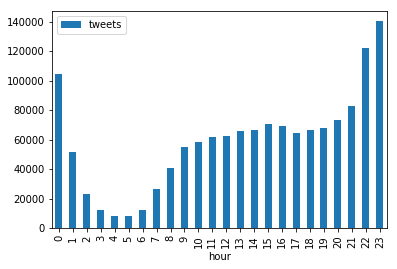

In [31]:
tweets_hour_pd = tweets_hour.toPandas()
tweets_hour_pd.plot.bar(x="hour", y="tweets")

## **Parte 4:** Introducción a los datos relacionales

El hecho de trabajar con una base de datos que contiene información generada en una red social nos permite introducir el concepto de datos relacionales. Podemos definir datos relacionales como aquellos en los que existen relaciones entre las entidades que constituyen la base de datos. Si estas relaciones son binarias, relaciones 1 a 1, podemos representar las relaciones como un grafo compuesto por un conjunto de vértices $\mathcal{V}$ y un conjunto de aristas $\mathcal{E}$ que los relacionan.

En el caso de grafos que emergen de manera orgánica, este tipo de estructura va más allá de los grafos regulares que seguramente conocéis. Este tipo de estructuras se conocen como [redes complejas](https://es.wikipedia.org/wiki/Red_compleja). El estudio de la estructura y dinámicas de este tipo de redes ha contribuido a importantes resultados en campos tan dispares como la física, la sociología, la ecología o la medicina.

![complex_network](https://images.squarespace-cdn.com/content/5150aec6e4b0e340ec52710a/1364574727391-XVOFAB9P6GHKTDAH6QTA/lastfm_800_graph_white.png?content-type=image%2Fpng)

En esta última parte de la práctica vamos a trabajar con este tipo de datos. En concreto vamos a modelar uno de los posibles relaciones presentes en el dataset, la red de retweets.

### Generar la red de retweets

#### **Parte 4.1**: Construcción de la edgelist

Lo primero se os pide es que generéis la red. Hay diversas maneras de representar una red compleja, por ejemplo, si estuvierais interesados en trabajar en ellas desde el punto de vista teórico, la manera más habitual de representarlas es utilizando una [matriz de adyacencia](https://es.wikipedia.org/wiki/Matriz_de_adyacencia). En esta práctica vamos a centrarnos en el aspecto computacional, una de las maneras de mas eficientes (computacionalmente hablando) de representar una red es mediante su [*edge list*](https://en.wikipedia.org/wiki/Edge_list), una tabla que especifica la relación a parejas entre las entidades.

Las relaciones pueden ser bidireccionales o direccionales y tener algún peso asignado o no (weighted or unweighted). En el caso que nos ocupa, estamos hablando de una red dirigida, un usuario retuitea a otro, y podemos pensarla teniendo en cuenta cuántas veces esto ha pasado.

Lo primero que haréis para simplificar el cómputo,  es crear un sample homogéneo sin reemplazo del 1% de los tweets. Utilizando los conocimientos que habéis aprendido en el apartado 3.1. Utilizaremos 42 como valor para la seed.

In [32]:
sample = tweets.sample(False, 0.01, 42).persist()

Ahora vais a crear una tabla ```edgelist``` con la siguiente información:
- ***src:*** usuario que retuitea
- ***dst:*** usuario que es retuiteado
- ***weight:*** número de veces que un usuario retuitea a otro.

Filtrar el resultado para que contenga sólo las relaciones con un weight igual o mayor a dos.

In [33]:
edgelist = sample.where("retweeted_status IS NOT NULL")\
                 .selectExpr("user.screen_name AS src", "retweeted_status.user.screen_name AS dst")

edgelist = edgelist.groupBy("src", "dst").count().withColumnRenamed("count", "weight").where("weight >= 2")

L = edgelist.count()

print("There are {0} edges on the network.".format(L))

There are 5243 edges on the network.


In [35]:
assert L == 5247, "Incorrect ouput"

AssertionError: Incorrect ouput

#### **Parte 4.2:** Centralidad de grado

Uno de los descriptores más comunes en el análisis de redes es el grado. El grado cuantifica cuántas aristas están conectadas a cada vértices. En el caso de redes dirigidas como la que acabamos de crear este descriptor está descompuesto en el:
- **in degree**: cuantas aristas apuntan al nodo
- **out degree**: cuantas aristas salen del nodo

Si haces un ranquing de estos valores vais a obtener medida de centralidad, la [centralidad de grado](https://en.wikipedia.org/wiki/Centrality#Degree_centrality), de cada uno de los nodos.

Se os pide que generéis una tabla con la información:
- ***screen_name:*** nombre del usuario (anteriormene src).
- ***outDegree:*** out degree del nodo.

Ordenado la tabla por out degree en orden descendente.

In [34]:
from pyspark.sql.functions import col

outDegree = edgelist.groupBy("src").agg({"dst": "count"}).withColumnRenamed("count(dst)", "outDegree").orderBy("outDegree", ascending=False)

outDegree.limit(20).show()

+---------------+---------+
|            src|outDegree|
+---------------+---------+
|   rosavergar23|       12|
|     carrasquem|       10|
|Teresaperezcep1|       10|
|  joanagabarrof|        9|
|MarcoCostaValue|        9|
|     pallaron12|        9|
|   Socialista60|        8|
|    SSarelvis67|        8|
|JulioAl18175505|        8|
|       jasalo54|        8|
|MariaJo40891027|        8|
|   Pepa63306772|        7|
|    RosaMar6254|        7|
|     Nacho_JISF|        7|
|     nusagatero|        7|
|      ISMVALSyR|        7|
|    mariaje1956|        7|
|      el_partal|        7|
|        lyuva26|        7|
|  PabloChabolas|        6|
+---------------+---------+



In [35]:
output = outDegree.first()
assert output.screen_name == "rosavergar23" and output.outDegree == 11, "Incorrect output"

AttributeError: screen_name

Se os pide ahora que generéis una tabla con la información:
- ***screen_name:*** nombre del usuario (anteriormente dst).
- ***inDegree:*** in degree del nodo.

Ordenad la tabla por in degree en orden descendente.

In [86]:
# Replicando el código utilizado para generar el outDegree, generad el inDegree
inDegree = edgelist.groupBy("dst").agg({"src": "count"}).withColumnRenamed("count(src)", "inDegree").orderBy("inDegree", ascending=False)

inDegree.limit(20).show()

+---------------+--------+
|            dst|inDegree|
+---------------+--------+
|         vox_es|     321|
|   ahorapodemos|     275|
|           PSOE|     256|
|   CiudadanosCs|     202|
|  Santi_ABASCAL|     200|
|      populares|     133|
|  AlbanoDante76|     105|
|           KRLS|      93|
|Front_Republica|      90|
|Pablo_Iglesias_|      80|
|       ivanedlm|      70|
|       iescolar|      70|
|sanchezcastejon|      69|
|         boye_g|      57|
| AntonioMaestre|      56|
|      JuntsXCat|      56|
| hermanntertsch|      55|
|     eldiarioes|      46|
|   pablocasado_|      40|
|    CastigadorY|      39|
+---------------+--------+



In [ ]:
output = inDegree.first()
assert output.screen_name == "vox_es" and output.inDegree == 330, "Incorrect output"